##### DISCO Network Graph

[nltk_data] Downloading package punkt to /Users/QuangAP/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/QuangAP/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Top 10 texts that have context similarity to 'education':
Text 1: new class cyber becoming important technology company insert new genus artificial intelligence software business consumer product red hacking mean load date august (Similarity: 0.2352879348682288)
Text 2: ka ho article journal report innovation work suggests important impact genus artificial intelligence may lie narrowing productivity gap low skilled worker high skilled one drawing graphic diagram drawing load date may (Similarity: 0.22589820554543077)
Text 3: price plan invest billion genus artificial intelligence technology u operation next three year recruiting ai worker training existing staff ai capability photo graphic photograph load date april (Similarity: 0.22095665694443017)
Text 4: genus artificial intelligence tool promise fix common red flag used identify bog email text used phi attack load date september (Similarity: 0.22027134489757388)
Text 5: ti testing chat powered genus artificial intelligence designed

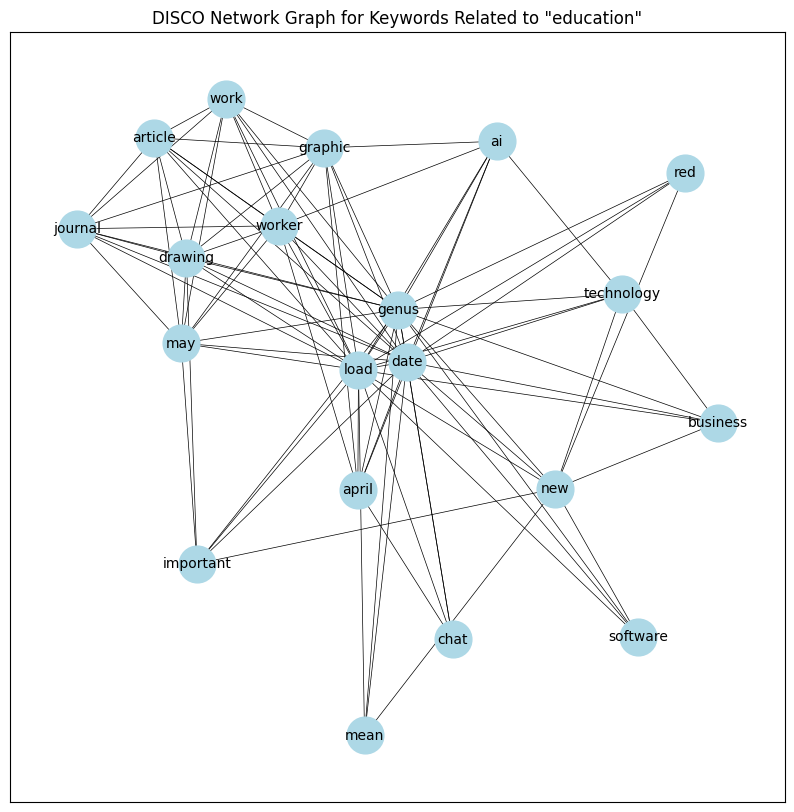

In [39]:
import pandas as pd
import json
import numpy as np
import torch
from transformers import BertTokenizer, BertModel
import matplotlib.pyplot as plt
import networkx as nx
from collections import Counter
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import nltk

nltk.download('punkt')
nltk.download('stopwords')

def initialize_model():
    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
    model = BertModel.from_pretrained('bert-base-uncased')
    model.eval()  # Ensure the model is in evaluation mode
    return tokenizer, model

def preprocess_text(text, compound_words):
    for phrase in compound_words:
        text = text.replace(phrase, phrase.replace(" ", "_"))
    return text

def load_embeddings(input_file_path):
    embeddings = pd.read_csv(input_file_path).values
    return embeddings

def find_similar_words(input_file_path, word, tokenizer, model, tokenized_file_path, top_k=10):
    embeddings = load_embeddings(input_file_path)

    inputs = tokenizer(word, return_tensors='pt')
    with torch.no_grad():
        word_embedding = model(**inputs).last_hidden_state.mean(dim=1).squeeze().numpy()

    similarities = []
    for i, embedding in enumerate(embeddings):
        similarity = np.dot(word_embedding, embedding) / (np.linalg.norm(word_embedding) * np.linalg.norm(embedding))
        similarities.append((i, similarity))
    similarities.sort(key=lambda x: x[1], reverse=True)

    similar_indices = [index for index, _ in similarities[:top_k]]

    with open(tokenized_file_path, 'r', encoding='utf-8') as f:
        tokenized_corpus = json.load(f)

    if not isinstance(tokenized_corpus, list) or not all(isinstance(item, dict) and 'Text' in item for item in tokenized_corpus):
        raise ValueError(f"{tokenized_file_path} does not have the expected structure.")

    similar_texts = [tokenized_corpus[i]['Text'] for i in similar_indices]

    # Debugging: Print the most similar texts and their similarities
    print(f"Top {top_k} texts that have context similarity to '{word}':")
    for i, (index, sim) in enumerate(similarities[:top_k]):
        print(f"Text {i+1}: {tokenized_corpus[index]['Text']} (Similarity: {sim})")

    return similar_texts

def extract_keywords(texts):
    stop_words = set(stopwords.words('english'))
    all_words = []
    for text in texts:
        words = word_tokenize(text)
        filtered_words = [word for word in words if word.isalpha() and word.lower() not in stop_words]
        all_words.extend(filtered_words)
    word_counts = Counter(all_words)
    common_words = [word for word, _ in word_counts.most_common(20)]
    return common_words

def build_graph(keywords, texts):
    G = nx.Graph()
    for keyword in keywords:
        G.add_node(keyword)
    
    co_occurrence_threshold = 2
    co_occurrences = Counter()
    
    for text in texts:
        text_keywords = [word for word in word_tokenize(text) if word in keywords]
        for i in range(len(text_keywords)):
            for j in range(i + 1, len(text_keywords)):
                pair = tuple(sorted((text_keywords[i], text_keywords[j])))
                co_occurrences[pair] += 1

    for (keyword1, keyword2), count in co_occurrences.items():
        if count >= co_occurrence_threshold:
            G.add_edge(keyword1, keyword2, weight=count)

    return G

def visualize_keywords(input_file_path, tokenized_file_path, target_word, compound_words=[], top_k=10):
    tokenizer, model = initialize_model()

    preprocessed_word = preprocess_text(target_word, compound_words).replace(" ", "_")
    similar_texts = find_similar_words(input_file_path, preprocessed_word, tokenizer, model, tokenized_file_path, top_k=top_k)

    similar_texts = [preprocess_text(text, compound_words) for text in similar_texts]

    keywords = extract_keywords(similar_texts)

    G = build_graph(keywords, similar_texts)

    plt.figure(figsize=(10, 10))
    pos = nx.spring_layout(G, k=0.3)
    nx.draw_networkx_nodes(G, pos, node_size=700, node_color='lightblue')
    nx.draw_networkx_edges(G, pos, edgelist=G.edges(data=True), width=0.5)
    nx.draw_networkx_labels(G, pos, font_size=10, font_weight='regular')
    plt.title(f'DISCO Network Graph for Keywords Related to "{target_word}"')
    plt.show()

# Example usage
input_file_path = 'vectorizedBERT_500.csv'
tokenized_file_path = 'tokenizedBERT_ID_500.json'
target_word = "education"
compound_words = ["artificial intelligence", "machine learning"]

visualize_keywords(input_file_path, tokenized_file_path, target_word, compound_words)


[nltk_data] Downloading package punkt to /Users/QuangAP/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/QuangAP/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


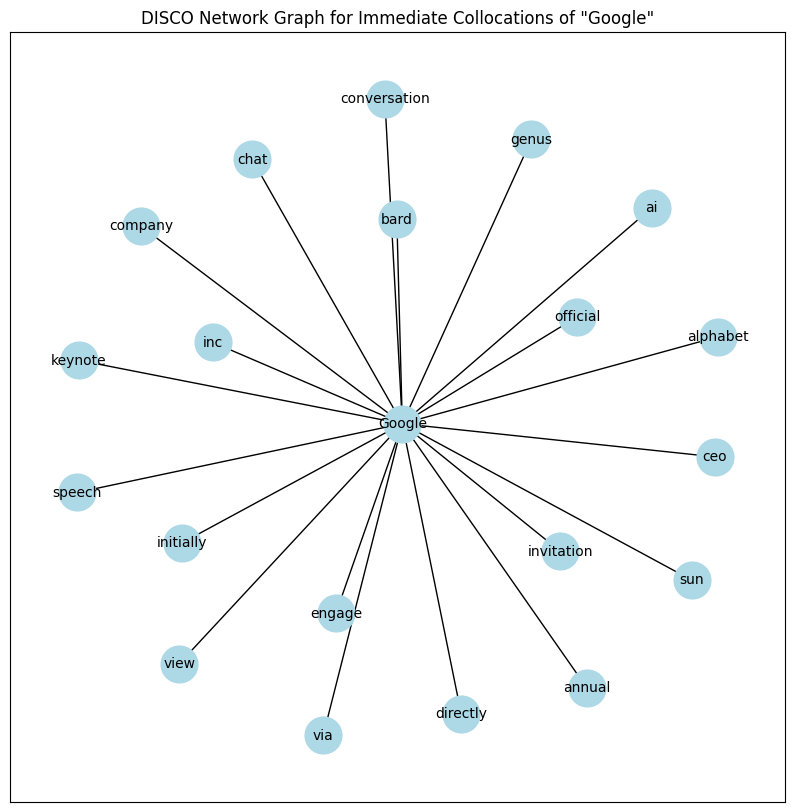

In [40]:
# Download NLTK resources
nltk.download('punkt')
nltk.download('stopwords')

# Load tokenizer and model
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')
model.eval()  # Ensure the model is in evaluation mode

# Function to load embeddings from CSV
def load_embeddings(input_file_path):
    embeddings = pd.read_csv(input_file_path).values
    return embeddings

# Function to find the most similar words based on cosine similarity
def find_similar_words(input_file_path, word, tokenizer, model, tokenized_file_path, top_k=10):
    embeddings = load_embeddings(input_file_path)

    inputs = tokenizer(word, return_tensors='pt')
    with torch.no_grad():
        word_embedding = model(**inputs).last_hidden_state.mean(dim=1).squeeze().numpy()

    similarities = []
    for i, embedding in enumerate(embeddings):
        similarity = np.dot(word_embedding, embedding) / (np.linalg.norm(word_embedding) * np.linalg.norm(embedding))
        similarities.append((i, similarity))
    similarities.sort(key=lambda x: x[1], reverse=True)

    similar_indices = [index for index, _ in similarities[:top_k]]

    # Load tokenized corpus (ensure correct structure)
    with open(tokenized_file_path, 'r', encoding='utf-8') as f:
        tokenized_corpus = json.load(f)

    # Verify the structure of tokenized_corpus
    if not isinstance(tokenized_corpus, list) or not all(isinstance(item, dict) and 'Text' in item for item in tokenized_corpus):
        raise ValueError(f"{tokenized_file_path} does not have the expected structure.")

    # Extract the similar words from the tokenized corpus
    similar_texts = [tokenized_corpus[i]['Text'] for i in similar_indices]

    return similar_texts

# Function to extract immediate collocations of the word
def extract_collocations(word, texts, window_size=2):
    collocations = []
    for text in texts:
        tokens = word_tokenize(text)
        for i, token in enumerate(tokens):
            if token.lower() == word.lower():
                start = max(0, i - window_size)
                end = min(len(tokens), i + window_size + 1)
                collocations.extend(tokens[start:i] + tokens[i+1:end])
    return collocations

# Example usage to find similar words to "innovation"
input_file_path = 'vectorizedBERT_500.csv'
tokenized_file_path = 'tokenizedBERT_ID_500.json'
word = "Google"
similar_texts = find_similar_words(input_file_path, word, tokenizer, model, tokenized_file_path)

# Extract collocations from similar texts
collocations = extract_collocations(word, similar_texts)

# Remove stopwords and keep only meaningful words
stop_words = set(stopwords.words('english'))
filtered_collocations = [collocation for collocation in collocations if collocation.isalpha() and collocation.lower() not in stop_words]

# Get the most common collocations
collocation_counts = Counter(filtered_collocations)
common_collocations = [collocation for collocation, _ in collocation_counts.most_common(20)]

# Build the DISCO network graph
G = nx.Graph()

# Add nodes and edges
G.add_node(word)
for collocation in common_collocations:
    G.add_node(collocation)
    G.add_edge(word, collocation)

# Draw the network graph
plt.figure(figsize=(10, 10))
nx.draw_networkx(G, with_labels=True, node_size=700, node_color='lightblue', font_size=10, font_weight='regular')
plt.title(f'DISCO Network Graph for Immediate Collocations of "{word}"')
plt.show()


Similar texts: ['ti testing chat powered genus artificial_intelligence designed help user find content get recommendation load date may', 'afar bell letter responds peggy noon april declaration column danger genus artificial_intelligence open chat load date april', 'bai un new genus artificial_intelligence model claim rival chat part effort lead race ai development world second largest economy load date october', 'james mackenzie letter responds peggy noon april declaration column danger genus artificial_intelligence open chat load date april', 'genus artificial_intelligence tool promise fix common red flag used identify bog email text used phi attack load date september', 'int released genus artificial_intelligence tool int assist offer customer financial recommendation plan build staff eight full time moderator review go come large language model load date october', 'author artist internet publisher seeking compensation use work train genus ai photo graphic photograph load date augus

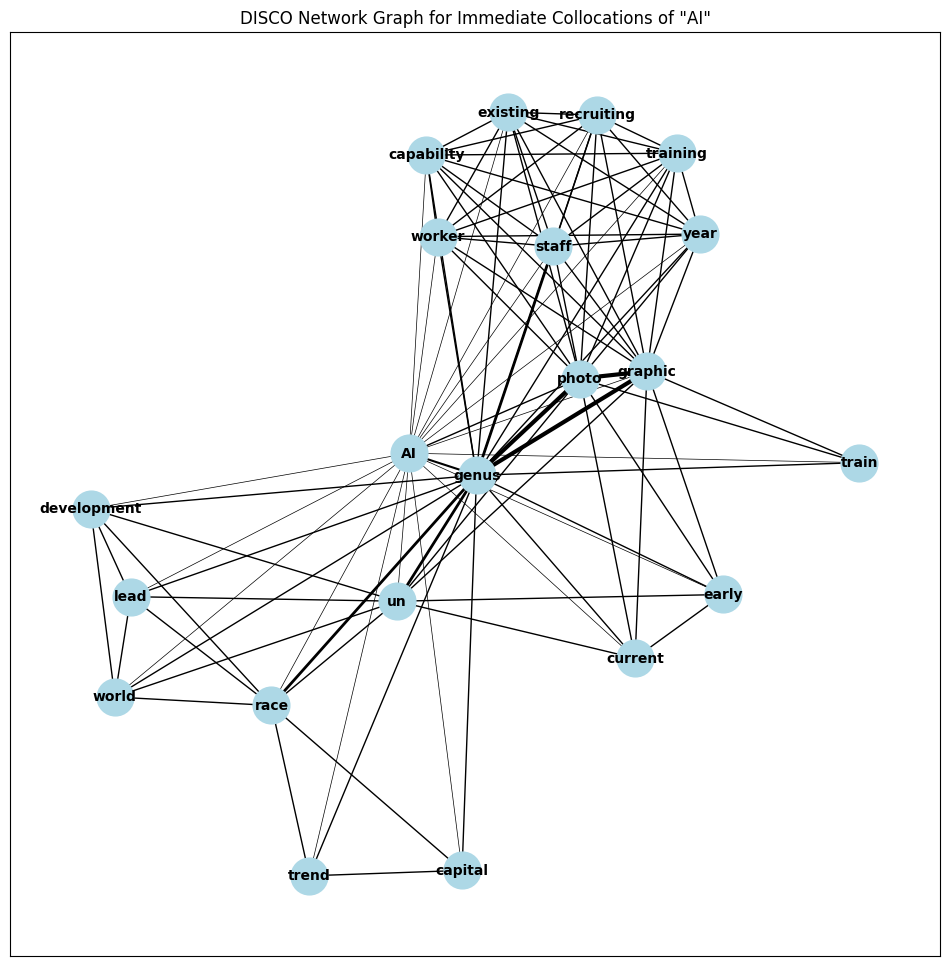

In [41]:
def extract_collocations(word, texts, window_size=2):
    collocations = []
    for text in texts:
        tokens = word_tokenize(text)
        for i, token in enumerate(tokens):
            if token.lower() == word.lower():
                start = max(0, i - window_size)
                end = min(len(tokens), i + window_size + 1)
                collocations.extend(tokens[start:i] + tokens[i+1:end])
    return collocations

def filter_and_count_collocations(collocations):
    stop_words = set(stopwords.words('english'))
    filtered_collocations = [collocation for collocation in collocations if collocation.isalpha() and collocation.lower() not in stop_words]
    collocation_counts = Counter(filtered_collocations)
    common_collocations = [collocation for collocation, _ in collocation_counts.most_common(20)]
    return common_collocations, collocation_counts

def build_graph(word, common_collocations, collocation_counts, similar_texts):
    G = nx.Graph()
    G.add_node(word)

    for collocation in common_collocations:
        G.add_node(collocation)
        G.add_edge(word, collocation, weight=collocation_counts[collocation])

    for i, collocation1 in enumerate(common_collocations):
        for j, collocation2 in enumerate(common_collocations):
            if i != j:
                co_occurrence_count = sum(1 for text in similar_texts if collocation1 in word_tokenize(text) and collocation2 in word_tokenize(text))
                if co_occurrence_count > 0:
                    if G.has_edge(collocation1, collocation2):
                        G[collocation1][collocation2]['weight'] += co_occurrence_count
                    else:
                        G.add_edge(collocation1, collocation2, weight=co_occurrence_count)
    
    return G

def visualize_keywords(input_file_path, tokenized_file_path, target_word, compound_words=[], top_k=10):
    tokenizer, model = initialize_model()

    preprocessed_word = preprocess_text(target_word, compound_words).replace(" ", "_")
    similar_texts = find_similar_words(input_file_path, preprocessed_word, tokenizer, model, tokenized_file_path, top_k=top_k)

    similar_texts = [preprocess_text(text, compound_words) for text in similar_texts]

    # Debug: Print similar texts
    print("Similar texts:", similar_texts)

    collocations = extract_collocations(target_word, similar_texts)

    # Debug: Print collocations
    print("Collocations:", collocations)

    common_collocations, collocation_counts = filter_and_count_collocations(collocations)

    # Debug: Print common collocations and their counts
    print("Common collocations:", common_collocations)
    print("Collocation counts:", collocation_counts)

    G = build_graph(target_word, common_collocations, collocation_counts, similar_texts)

    # Debug: Print graph nodes and edges
    print("Graph nodes:", G.nodes())
    print("Graph edges:", G.edges(data=True))

    plt.figure(figsize=(12, 12))
    pos = nx.spring_layout(G, k=0.3)
    nx.draw_networkx_nodes(G, pos, node_size=700, node_color='lightblue')
    nx.draw_networkx_edges(G, pos, edgelist=G.edges(data=True), width=[d.get('weight', 1) * 0.5 for (u, v, d) in G.edges(data=True)])
    nx.draw_networkx_labels(G, pos, font_size=10, font_weight='bold')
    plt.title(f'DISCO Network Graph for Immediate Collocations of "{target_word}"')
    plt.show()

# Example usage
input_file_path = 'vectorizedBERT_500.csv'
tokenized_file_path = 'tokenizedBERT_ID_500.json'
target_word = "AI"
compound_words = ["machine learning", "artificial intelligence"]

visualize_keywords(input_file_path, tokenized_file_path, target_word, compound_words)

##### DISCO graph for compound words (artificial intelligence)

[nltk_data] Downloading package punkt to /Users/QuangAP/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/QuangAP/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


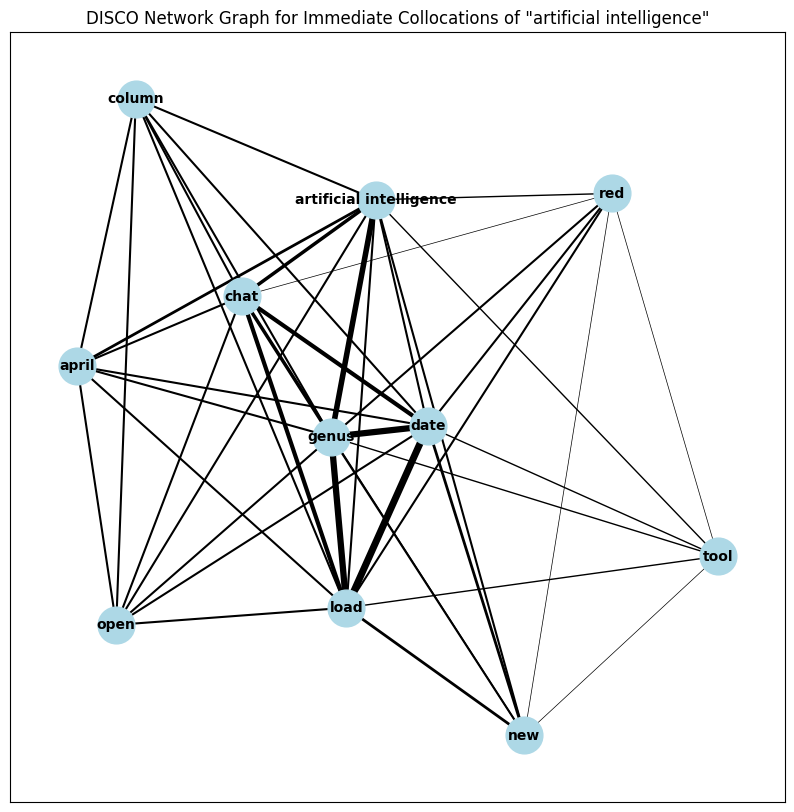

In [42]:
import pandas as pd
import json
import numpy as np
import torch
from transformers import BertTokenizer, BertModel
import matplotlib.pyplot as plt
import networkx as nx
from collections import Counter
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import nltk

nltk.download('punkt')
nltk.download('stopwords')

# Function to initialize the tokenizer and model
def initialize_model():
    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
    model = BertModel.from_pretrained('bert-base-uncased')
    model.eval()  # Ensure the model is in evaluation mode
    return tokenizer, model

# Function to preprocess text to handle compound words
def preprocess_text(text, compound_words):
    for phrase in compound_words:
        text = text.replace(phrase, phrase.replace(" ", "_"))
    return text

# Function to load embeddings from CSV
def load_embeddings(input_file_path):
    embeddings = pd.read_csv(input_file_path).values
    return embeddings

# Function to find the most similar words based on cosine similarity
def find_similar_words(input_file_path, word, tokenizer, model, top_k=10):
    embeddings = load_embeddings(input_file_path)

    inputs = tokenizer(word, return_tensors='pt')
    with torch.no_grad():
        word_embedding = model(**inputs).last_hidden_state.mean(dim=1).squeeze().numpy()

    similarities = []
    for i, embedding in enumerate(embeddings):
        similarity = np.dot(word_embedding, embedding) / (np.linalg.norm(word_embedding) * np.linalg.norm(embedding))
        similarities.append((i, similarity))
    similarities.sort(key=lambda x: x[1], reverse=True)

    return similarities[:top_k]

# Function to extract collocations
def extract_collocations(word, similar_texts, window_size=5):
    collocations = []
    for text in similar_texts:
        tokens = word_tokenize(text)
        if word in tokens:
            index = tokens.index(word)
            window = tokens[max(0, index - window_size):min(len(tokens), index + window_size + 1)]
            collocations.extend(window)
    return collocations

# Function to filter and count collocations
def filter_and_count_collocations(collocations, target_word):
    stop_words = set(stopwords.words('english'))
    filtered_collocations = [token.replace("_", " ") for token in collocations if token.isalpha() and token.lower() not in stop_words]
    collocation_counter = Counter(filtered_collocations)
    common_collocations = [item for item, count in collocation_counter.most_common(10) if item.replace("_", " ") != target_word]
    return common_collocations, collocation_counter

# Function to build the DISCO network graph
def build_graph(target_word, common_collocations, collocation_counter, similar_texts):
    G = nx.Graph()
    G.add_node(target_word)

    for collocation in common_collocations:
        G.add_node(collocation)
        G.add_edge(target_word, collocation, weight=collocation_counter[collocation])

    for i in range(len(common_collocations)):
        for j in range(i + 1, len(common_collocations)):
            count = sum(1 for text in similar_texts if common_collocations[i] in text and common_collocations[j] in text)
            if count > 0:
                G.add_edge(common_collocations[i], common_collocations[j], weight=count)
    
    return G

# Function to visualize the DISCO network graph
def visualize_keywords(input_file_path, tokenized_file_path, target_word, compound_words=[], top_k=10):
    tokenizer, model = initialize_model()

    preprocessed_word = preprocess_text(target_word, compound_words).replace(" ", "_")
    similarities = find_similar_words(input_file_path, preprocessed_word, tokenizer, model, top_k=top_k)

    similar_indices = [index for index, _ in similarities]

    with open(tokenized_file_path, 'r', encoding='utf-8') as f:
        tokenized_corpus = json.load(f)

    if not isinstance(tokenized_corpus, list) or not all(isinstance(item, dict) and 'Text' in item for item in tokenized_corpus):
        raise ValueError("tokenizedBERT_ID_500.json does not have the expected structure.")

    similar_texts = [tokenized_corpus[i]['Text'] for i in similar_indices]
    similar_texts = [preprocess_text(text, compound_words) for text in similar_texts]

    collocations = extract_collocations(preprocessed_word, similar_texts)
    common_collocations, collocation_counter = filter_and_count_collocations(collocations, target_word)

    G = build_graph(target_word, common_collocations, collocation_counter, similar_texts)

    plt.figure(figsize=(10, 10))
    pos = nx.spring_layout(G, k=0.3)
    nx.draw_networkx_nodes(G, pos, node_size=700, node_color='lightblue')
    nx.draw_networkx_edges(G, pos, edgelist=G.edges(data=True), width=[d.get('weight', 0.5) * 0.5 for (u, v, d) in G.edges(data=True)])
    nx.draw_networkx_labels(G, pos, font_size=10, font_weight='bold')
    plt.title(f'DISCO Network Graph for Immediate Collocations of "{target_word}"')
    plt.show()

# Example usage
input_file_path = 'vectorizedBERT_500.csv'
tokenized_file_path = 'tokenizedBERT_ID_500.json'
target_word = "artificial intelligence"
compound_words = ["artificial intelligence"]

visualize_keywords(input_file_path, tokenized_file_path, target_word, compound_words)


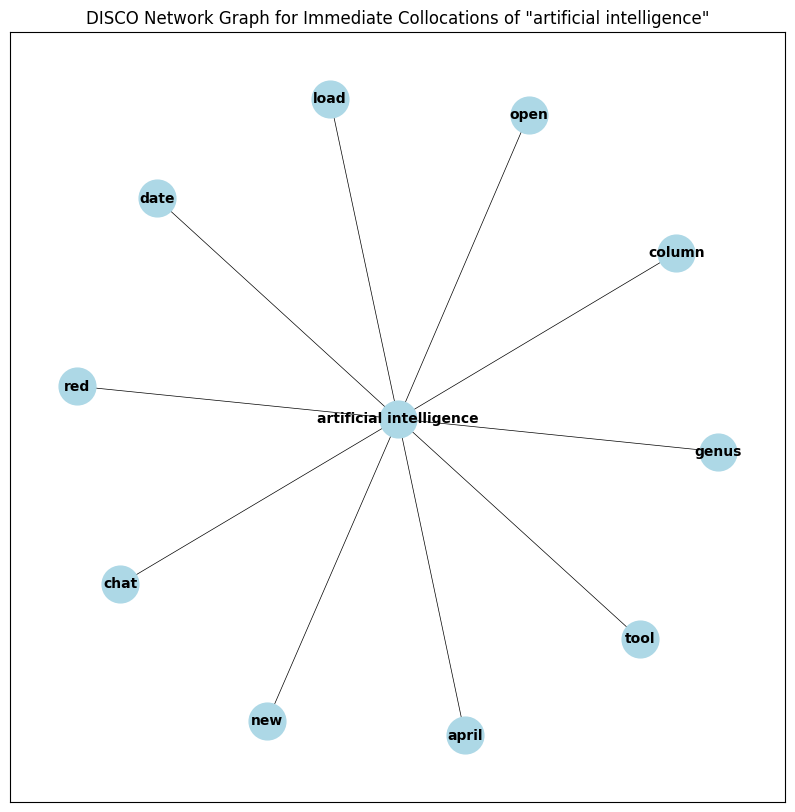

In [43]:
# Function to preprocess text to handle compound words
def preprocess_text(text, compound_words):
    for phrase in compound_words:
        text = text.replace(phrase, phrase.replace(" ", "_"))
    return text

# Function to load embeddings from CSV
def load_embeddings(input_file_path):
    embeddings = pd.read_csv(input_file_path).values
    return embeddings

# Function to find the most similar words based on cosine similarity
def find_similar_words(input_file_path, word, tokenizer, model, top_k=10):
    embeddings = load_embeddings(input_file_path)

    inputs = tokenizer(word, return_tensors='pt')
    with torch.no_grad():
        word_embedding = model(**inputs).last_hidden_state.mean(dim=1).squeeze().numpy()

    similarities = []
    for i, embedding in enumerate(embeddings):
        similarity = np.dot(word_embedding, embedding) / (np.linalg.norm(word_embedding) * np.linalg.norm(embedding))
        similarities.append((i, similarity))
    similarities.sort(key=lambda x: x[1], reverse=True)

    return similarities[:top_k]

# Function to extract collocations from similar texts
def extract_collocations(similar_texts, target_word):
    collocations = []
    for text in similar_texts:
        tokens = word_tokenize(text)
        if target_word in tokens:
            index = tokens.index(target_word)
            window = tokens[max(0, index - 5):min(len(tokens), index + 6)]
            collocations.extend(window)
    return collocations

# Function to build the DISCO network graph
def build_graph(word, common_collocations):
    G = nx.Graph()
    G.add_node(word)
    for collocation in common_collocations:
        G.add_node(collocation)
        G.add_edge(word, collocation)
    return G

# Example usage function
def visualize_collocations(input_file_path, target_word, compound_words, top_k=10):
    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
    model = BertModel.from_pretrained('bert-base-uncased')
    model.eval()  # Ensure the model is in evaluation mode

    preprocessed_word = target_word.replace(" ", "_")
    similarities = find_similar_words(input_file_path, preprocessed_word, tokenizer, model, top_k=top_k)

    # Retrieve the top similar words and their indices
    similar_indices = [index for index, _ in similarities]
    embeddings = load_embeddings(input_file_path)

    # Load tokenized corpus (ensure correct structure)
    with open('tokenizedBERT_ID_500.json', 'r', encoding='utf-8') as f:
        tokenized_corpus = json.load(f)

    # Verify the structure of tokenized_corpus
    if not isinstance(tokenized_corpus, list) or not all(isinstance(item, dict) and 'Text' in item for item in tokenized_corpus):
        raise ValueError("tokenizedBERT_ID_500.json does not have the expected structure.")

    # Extract the similar texts from the tokenized corpus
    similar_texts = [tokenized_corpus[i]['Text'] for i in similar_indices]

    # Preprocess similar texts to handle compound words
    similar_texts = [preprocess_text(text, compound_words) for text in similar_texts]

    # Extract collocations
    collocations = extract_collocations(similar_texts, preprocessed_word)

    # Remove stopwords and non-alphabetic tokens, and restore spaces in compound words
    stop_words = set(stopwords.words('english'))
    filtered_collocations = [token.replace("_", " ") for token in collocations if token.isalpha() and token.lower() not in stop_words]

    # Count collocations and filter common ones
    collocation_counter = Counter(filtered_collocations)
    common_collocations = [item for item, count in collocation_counter.most_common(10) if item.replace("_", " ") != target_word]

    # Build the DISCO network graph
    G = build_graph(target_word, common_collocations)

    # Draw the network graph
    plt.figure(figsize=(10, 10))
    pos = nx.spring_layout(G, k=0.3)
    nx.draw_networkx_nodes(G, pos, node_size=700, node_color='lightblue')
    nx.draw_networkx_edges(G, pos, edgelist=G.edges(data=True), width=[0.5 if 'weight' not in d else d['weight']*0.5 for (u, v, d) in G.edges(data=True)])
    nx.draw_networkx_labels(G, pos, font_size=10, font_weight='bold')
    plt.title(f'DISCO Network Graph for Immediate Collocations of "{target_word}"')
    plt.show()

# Example usage: visualize collocations for "machine learning"
input_file_path = 'vectorizedBERT_500.csv'
target_word = "artificial intelligence"
compound_words = ["artificial intelligence"]
visualize_collocations(input_file_path, target_word, compound_words)
